# 01 — Frequency Response: Spectral Attention (Gain & Phase)

We visualize the *per-frequency* behavior of SpectralAttention:
- **Gain** = `exp(log_gain)` per rFFT/DCT bin
- **Phase** = learned phase shift per bin (rFFT only)

Steps:
1) Initialize rFFT/DCT bins with a forward pass at target sequence length `T`
2) Plot mean gain/phase across heads
3) (Optional) nudge with a tiny train loop and re-plot
4) Compare **rFFT vs DCT** gains


In [1]:
import os, json
import torch
import matplotlib.pyplot as plt

from spectral_attention import SpectralAttention
from spectral_attention.blocks import SpectralEncoder  # if you want to visualize inside a stack

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## Helper: locate the SpectralAttention module to inspect

In [2]:
def get_attn_module(model):
    """
    Accepts either:
      - a single SpectralAttention module, or
      - a SpectralEncoder stack (returns first block's attn)
      - or any object with `attn` attribute
    """
    if isinstance(model, SpectralAttention):
        return model
    if isinstance(model, SpectralEncoder):
        return model.layers[0].attn
    if hasattr(model, "attn"):
        return model.attn
    raise TypeError("Could not locate SpectralAttention module in the given model.")


## Instantiate model (choose rFFT or DCT) & init bins

In [3]:
# Choose sequence length and width for inspection
T = 4096
D = 512
H = 8

# OPTION A (simple): single spectral block
m = SpectralAttention(d_model=D, n_heads=H, use_dct=False).to(device)  # set use_dct=True to view DCT

# OPTION B (stack): comment A out if you use this
# m = SpectralEncoder(depth=2, d_model=D, n_heads=H, use_dct=False, dropout=0.1).to(device)

# IMPORTANT: do a dummy forward at length T so spectral bins are created accordingly
with torch.no_grad():
    _ = m(torch.randn(1, T, D, device=device))

attn = get_attn_module(m)
attn.log_gain.shape, attn.phase.shape


(torch.Size([8, 2049]), torch.Size([8, 2049]))

## Plot helper

In [4]:
def plot_gain_phase(attn, title_prefix=""):
    gain  = torch.exp(attn.log_gain).mean(0).detach().cpu().numpy()   # [n_bins]
    phase = attn.phase.mean(0).detach().cpu().numpy()                 # [n_bins]

    fig, ax = plt.subplots(2, 1, figsize=(9, 6), tight_layout=True)
    ax[0].plot(gain)
    ax[0].set_title(f"{title_prefix}Mean Gain over rFFT/DCT bins")
    ax[0].set_xlabel("frequency bin"); ax[0].set_ylabel("gain")

    ax[1].plot(phase)
    ax[1].set_title(f"{title_prefix}Mean Phase over rFFT bins")
    ax[1].set_xlabel("frequency bin"); ax[1].set_ylabel("phase (rad)")
    return fig, ax


## Plot initial (pre-train) response

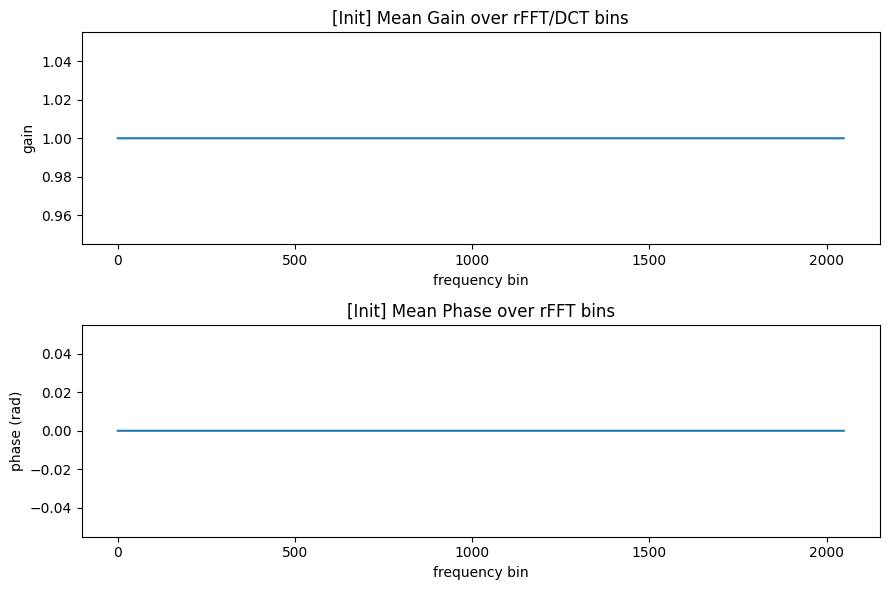

In [5]:
fig, ax = plot_gain_phase(attn, title_prefix="[Init] ")
plt.show()


## tiny training loop to nudge the mask

In [6]:
import torch.nn as nn

steps = 100
lr = 3e-4

# simple regression target to create gradients
x = torch.randn(8, T, D, device=device)
y = torch.randn(8, T, D, device=device)

model = m
model.train()
opt = torch.optim.AdamW(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

for s in range(1, steps+1):
    opt.zero_grad(set_to_none=True)
    yhat = model(x)
    loss = loss_fn(yhat, y)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()
    if s % 20 == 0:
        print(f"step {s:03d}  loss {loss.item():.4f}")

model.eval()


step 020  loss 1.8691
step 040  loss 1.6750
step 060  loss 1.5180
step 080  loss 1.3878
step 100  loss 1.2810


SpectralAttention(
  (W_qkv): Linear(in_features=512, out_features=1536, bias=True)
  (W_o): Linear(in_features=512, out_features=512, bias=True)
  (drop): Dropout(p=0.0, inplace=False)
)

## Plot after short training

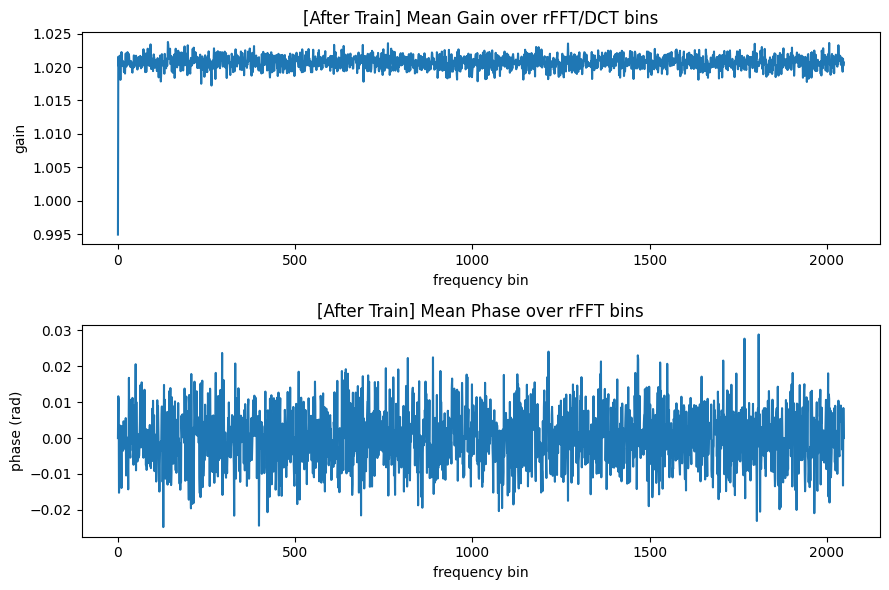

In [7]:
attn = get_attn_module(model)
fig, ax = plot_gain_phase(attn, title_prefix="[After Train] ")
plt.show()


## Compare rFFT vs DCT

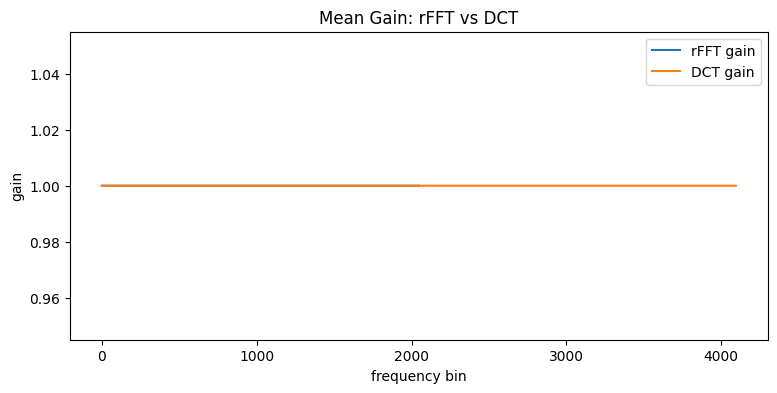

In [8]:
# rFFT
m_fft = SpectralAttention(d_model=D, n_heads=H, use_dct=False).to(device)
with torch.no_grad():
    _ = m_fft(torch.randn(1, T, D, device=device))
gain_fft = torch.exp(get_attn_module(m_fft).log_gain).mean(0).detach().cpu().numpy()

# DCT
m_dct = SpectralAttention(d_model=D, n_heads=H, use_dct=True).to(device)
with torch.no_grad():
    _ = m_dct(torch.randn(1, T, D, device=device))
gain_dct = torch.exp(get_attn_module(m_dct).log_gain).mean(0).detach().cpu().numpy()

plt.figure(figsize=(9,4))
plt.plot(gain_fft, label="rFFT gain")
plt.plot(gain_dct, label="DCT gain")
plt.title("Mean Gain: rFFT vs DCT")
plt.xlabel("frequency bin"); plt.ylabel("gain"); plt.legend()
plt.show()


## Save plots into experiments folder

'.\\experiments\\runs\\2025-09-07T1730Z_seq4k_fft\\artifacts\\freq_response.png'

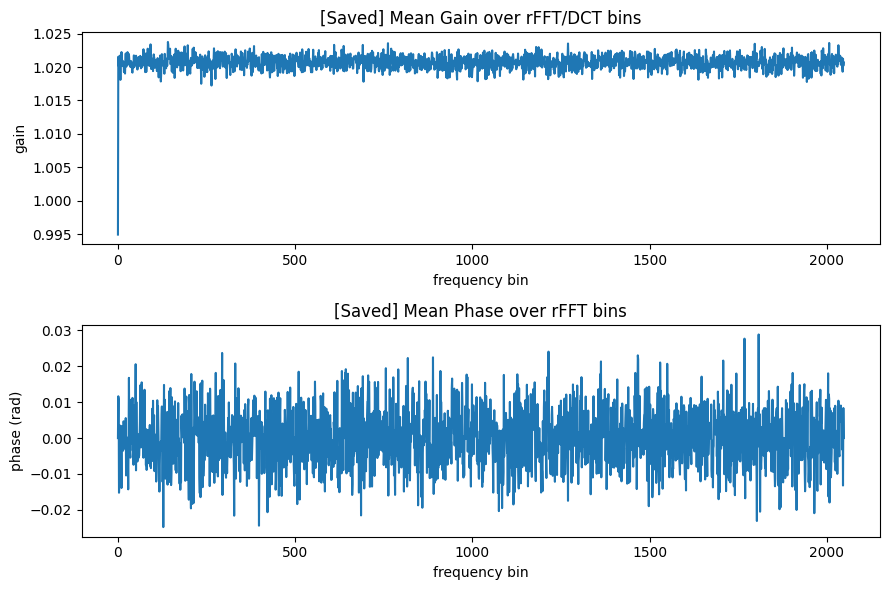

In [9]:
out_dir = r".\experiments\runs\2025-09-07T1730Z_seq4k_fft\artifacts"
os.makedirs(out_dir, exist_ok=True)

fig, ax = plot_gain_phase(get_attn_module(m), title_prefix="[Saved] ")
fig_path = os.path.join(out_dir, "freq_response.png")
fig.savefig(fig_path, dpi=150)
fig_path


## Optional: phase smoothness regularization metric

In [10]:
attn = get_attn_module(m)
tv = (attn.phase[:,1:] - attn.phase[:,:-1]).abs().mean()
float(tv)


0.025911342352628708

## Load from a checkpoint and plot (if you have one)

In [11]:
from pathlib import Path
import torch

# pick the same run dir used in the notebook examples (or choose your own)
ckpt_path = Path(r".\experiments\runs\2025-09-07T1730Z_seq4k_fft\artifacts\model_state.pt")
ckpt_path.parent.mkdir(parents=True, exist_ok=True)

# Grab the SpectralAttention module (first block if it's an encoder)
attn = get_attn_module(m)

# Save just the tensors you need for plotting
torch.save({
    "log_gain": attn.log_gain.detach().cpu(),
    "phase":    attn.phase.detach().cpu(),
}, ckpt_path)

ckpt_path, ckpt_path.exists()


(WindowsPath('experiments/runs/2025-09-07T1730Z_seq4k_fft/artifacts/model_state.pt'),
 True)

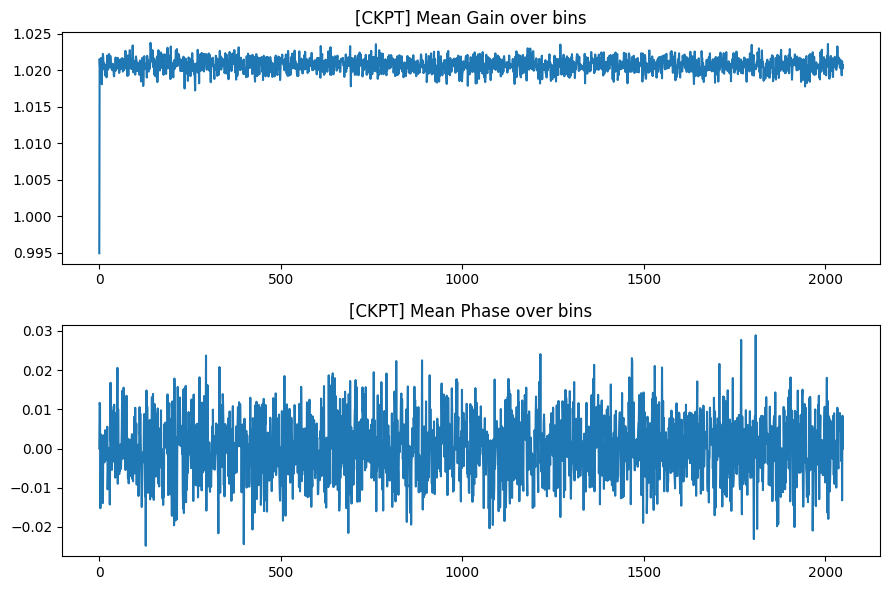

In [12]:
ckpt_path = r".\experiments\runs\2025-09-07T1730Z_seq4k_fft\artifacts\model_state.pt"
state = torch.load(ckpt_path, map_location="cpu")

def extract_log_gain_phase(state):
    if isinstance(state, dict) and "log_gain" in state and "phase" in state:
        return state["log_gain"], state["phase"]
    # dotted keys inside state_dict
    lg = next((state[k] for k in state if isinstance(k, str) and k.endswith("log_gain")), None)
    ph = next((state[k] for k in state if isinstance(k, str) and k.endswith("phase")), None)
    if lg is None or ph is None:
        raise RuntimeError("log_gain / phase not found in checkpoint.")
    return lg, ph

lg, ph = extract_log_gain_phase(state)
gain = torch.exp(lg).mean(0).numpy()
phase = ph.mean(0).numpy()

fig, ax = plt.subplots(2, 1, figsize=(9,6), tight_layout=True)
ax[0].plot(gain);  ax[0].set_title("[CKPT] Mean Gain over bins")
ax[1].plot(phase); ax[1].set_title("[CKPT] Mean Phase over bins")
plt.show()


## Notes

### Notes & Tips
- Always run one forward pass at sequence length **T** before plotting; that’s how the module sizes its spectral bins.
- **Interpretation**:
  - Low-frequency gain ↑ → stronger global mixing / long-range emphasis
  - High-frequency gain ↑ → sharper local detail
- **DCT vs rFFT**:
  - DCT is purely real (no phase curve).
  - rFFT provides both magnitude and phase.
- For smoother phase, try a tiny TV penalty during training:
  `loss += 1e-4 * (phase[:,1:] - phase[:,:-1]).abs().mean()`
